*Nos données datent de 1980, cependant l'accès aux données a évolué avec le temps et il se peut que certaines données soient manquantes. Néanmoins, les données sur les catastrophes naturelles restent cependant assez fiables*


# Import des librairies utilisées lors de l'analyse et traitement des données


In [6]:
# Importing libraries neeeded for the project
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Pré-traitement des données

Nettoyage des données du CSV : "Climate Disasters Frequency.csv"

In [7]:
# Lit le fichier csv et le stocke dans df_disasters
df_disasters = pd.read_csv("Climate Disasters Frequency.csv", delimiter=",")

# Supprime les colonnes inutiles
df_disasters = df_disasters.drop(columns=["ObjectId", "Country", "ISO2", "Unit", "Source", "CTS_Code", "CTS_Name", "CTS_Full_Descriptor"])

# Renomme les colonnes des années qui commencent par "F" en enlevant le "F" préfixe
df_disasters = df_disasters.rename(columns=lambda x: x[1:] if x.startswith("F") else x)
df_disasters = df_disasters.rename(columns={"Indicator": "Disaster"})
print(df_disasters)

# Renomme les valeurs de Disaster en gardant uniquement le nom de la catastrophe
str_to_remove = "Climate related disasters frequency, Number of Disasters: "
df_disasters["Disaster"] = df_disasters["Disaster"].str.replace(str_to_remove, "")

# Supprime les lignes où Disaster est égal à "TOTAL"
df_disasters = df_disasters[df_disasters["Disaster"] != "TOTAL"]

# Melt le dataframe pour avoir les années dans une colonne
df_disasters = df_disasters.melt(id_vars=["Disaster", "ISO3"], var_name="Year", value_name="Occurrences")


# Affiche le haut du dataframe
df_disasters.head()

    ISO3                                           Disaster  1980  1981  1982  \
0    AFG  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
1    AFG  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
2    AFG  Climate related disasters frequency, Number of...   1.0   NaN   NaN   
3    AFG  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
4    AFG  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
..   ...                                                ...   ...   ...   ...   
965  ZMB  Climate related disasters frequency, Number of...   NaN   1.0   NaN   
966  ZWE  Climate related disasters frequency, Number of...   NaN   1.0   NaN   
967  ZWE  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
968  ZWE  Climate related disasters frequency, Number of...   NaN   NaN   NaN   
969  ZWE  Climate related disasters frequency, Number of...   NaN   1.0   NaN   

     1983  1984  1985  1986

,Disaster,ISO3,Year,Occurrences
0,Drought,AFG,1980,NaN
1,Extreme temperature,AFG,1980,NaN
2,Flood,AFG,1980,1.0
3,Landslide,AFG,1980,NaN
4,Storm,AFG,1980,NaN


Nettoyage des données du CSV : "Atmospheric CO2 Concentrations.csv"

In [8]:
# Lit le fichier csv et le stocke dans df_emissions
df_emission = pd.read_csv('Atmospheric CO2 Concentrations.csv', delimiter=',')

# Supprime les lignes où l'unité est en pourcent
df_emission = df_emission[df_emission['Unit'] != 'Percent']

# Convertit les dates en datetime
df_emission['Date'] = pd.to_datetime(df_emission['Date'], format='%YM%m')

# Extrait l'année de la date et le rajoute dans une colonne "Year"
df_emission['Year'] = df_emission['Date'].dt.year

# Supprime les valeurs pour les années antérieures à 1980
df_emission = df_emission[df_emission['Year'] >= 1980]

# Groupe les données par année
df_emission = df_emission.groupby('Year')['Value'].mean().reset_index()
df_emission.head()

,Year,Value
0,1980,338.762500
1,1981,340.119167
2,1982,341.479167
3,1983,343.152500
4,1984,344.868333


Récupération des données du CSV: "Country Mapping.csv"

In [9]:
countries = pd.read_csv('Country Mapping.csv', delimiter=';')
countries = countries.rename(columns={'alpha-3': 'ISO3', 'name': 'Country', 'region': 'Region'}).drop(columns=['alpha-2', 'sub-region'])
countries.head() 

,Country,ISO3,Region
0,Afghanistan,AFG,Asia
1,Åland Islands,ALA,Europe
2,Albania,ALB,Europe
3,Algeria,DZA,Africa
4,American Samoa,ASM,Oceania


## Initialisation des DataFrame et variables

Création d'un dictionnaire des noms français des catastrophes étudiées

In [10]:
disasters_translation = {
    "Flood": "Inondation",
    "Drought": "Sécheresse",
    "Extreme temperature": "Température extrême",
    "Wildfire": "Feu de forêt",
    "Storm": "Tempête",
    "Landslide": "Glissement de terrain",
}

# Dataframe de la somme des catastrophe par année

In [11]:
# Transformation des données pour obtenir le total annuel des catastrophes à l'échelle mondiale

# Calculer la somme des catastrophes par année
global_disasters_per_year = df_disasters.groupby('Year')['Occurrences'].sum()

# Conversion en DataFrame pour faciliter les visualisations
df_global_disasters = global_disasters_per_year.reset_index()
df_global_disasters['Year'] = df_global_disasters['Year'].astype(int)
df_global_disasters


df_global_disasters.head()


,Year,Occurrences
0,1980,104.0
1,1981,112.0
2,1982,120.0
3,1983,157.0
4,1984,117.0


## Création d'un dataframe groupant par catastrophe et par année

In [12]:
# Dataframe avec les occurences de catastrophes par année dans le monde
df_disasters_world = df_disasters.groupby(["Disaster", "Year"]).sum("Occurrences").reset_index()
df_disasters_world.head()

,Disaster,Year,Occurrences
0,Drought,1980,24.0
1,Drought,1981,18.0
2,Drought,1982,6.0
3,Drought,1983,26.0
4,Drought,1984,6.0


# Graphiques

## Carte choroplète interactive

### Choix de la catastrophe à afficher

In [13]:
disaster = "Flood"

In [14]:
# Récupérer les données pour les inondations
df_disaster = df_disasters[df_disasters['Disaster'] == 'Flood']
df_disaster = df_disaster.merge(countries, on='ISO3')
print(df_disaster.head())

# Trouver les valeurs minimales et maximales de la colonne 'Flood' pour fixer l'échelle de couleur
min_echelle = df_disaster['Occurrences'].min()
max_echelle = df_disaster['Occurrences'].max()

# Créer une carte choroplèthe interactive avec Plotly Express
fig = px.choropleth(df_disaster, locations="ISO3",
                    color="Occurrences",
                    hover_name="Country",
                    animation_frame="Year",
                    color_continuous_scale='deep',
                    title=f'Traversée temporelle des pays impactés par les <i>{disasters_translation[disaster]}</i>',
                    range_color=[min_echelle, max_echelle],
                    width=800,  # Ajuster la largeur du graphique
                    height=600)  # Ajuster la hauteur du graphique

fig.show()

  Disaster ISO3  Year  Occurrences      Country Region
0    Flood  AFG  1980          1.0  Afghanistan   Asia
1    Flood  AFG  1981          NaN  Afghanistan   Asia
2    Flood  AFG  1982          NaN  Afghanistan   Asia
3    Flood  AFG  1983          NaN  Afghanistan   Asia
4    Flood  AFG  1984          NaN  Afghanistan   Asia


## Nuage de points

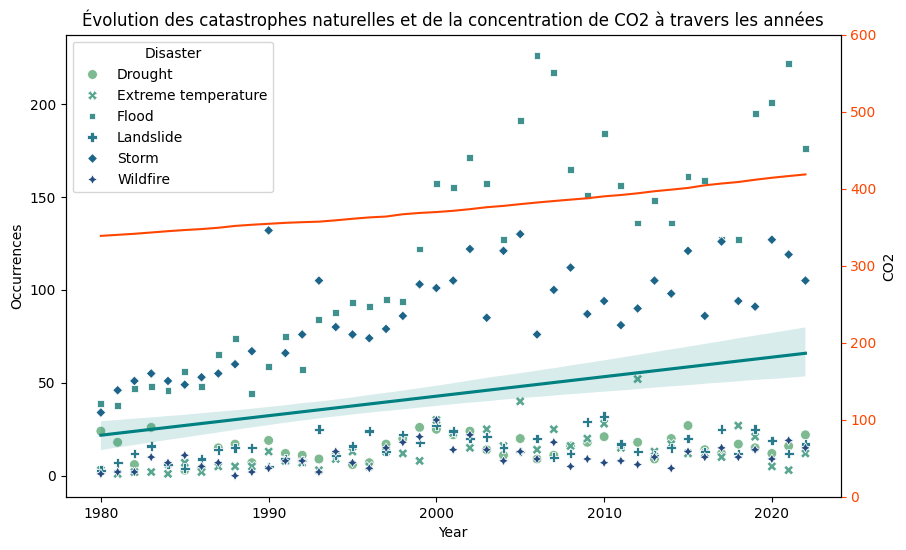

In [15]:
# Convertir 'Year' and 'Scale' en type numérique
df_disasters_world['Year'] = pd.to_numeric(df_disasters_world['Year'])
df_disasters_world['Occurrences'] = pd.to_numeric(df_disasters_world['Occurrences'])

# Créer un nuage de point avec différentes couleurs pour chaque indicateur
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_disasters_world,
    x="Year",
    y="Occurrences",
    hue="Disaster",  # Utilisee la colone 'Disaster' comme nuance
    style="Disaster",  # Utilisee la colone 'Disaster' comme style de point
    palette="crest",
    s=50, # Taille du point
)

# Surimpression d'une seule ligne de régression pour tous les points
sns.regplot(
    data=df_disasters_world,
    x="Year",
    y="Occurrences",
    scatter=False,  # Do not show individual points
    color='teal',  # Color of the regression line
)

# Créer un deuxième axe y pour la ligne de tendance des émissions de CO2
ax2 = plt.gca().twinx()  # Utilise plt.gca() pour obtenir l'axe actuel et le dupliquer

# Créer un graphique en ligne avec les émissions de CO2
sns.lineplot(data=df_emission[:-1], x="Year", y="Value", color='orangered', ax=ax2)

# Paramètres des axes
plt.ylabel('Scale', color='black')
ax2.set_ylabel('CO2')

# Ajuster les axes y pour commencer à 0
ax2.set_ylim(0, 600)

# Changer la couleur des nombres sur l'axe y
ax2.tick_params(axis='y', colors='orangered')

plt.title('Évolution des catastrophes naturelles et de la concentration de CO2 à travers les années')
plt.show()


# Graphique en barres empilées par année


Liste des catastrophes, ordonnée par le nombre de moyen de leur fréquence

In [16]:
# Calculer le total des occurrences par type de catastrophe
mean_per_type = df_disasters_world.groupby('Disaster')['Occurrences'].mean()

# Trier ces totals en ordre décroissant
sorted_types = mean_per_type.sort_values(ascending=False).index

Création du diagramme

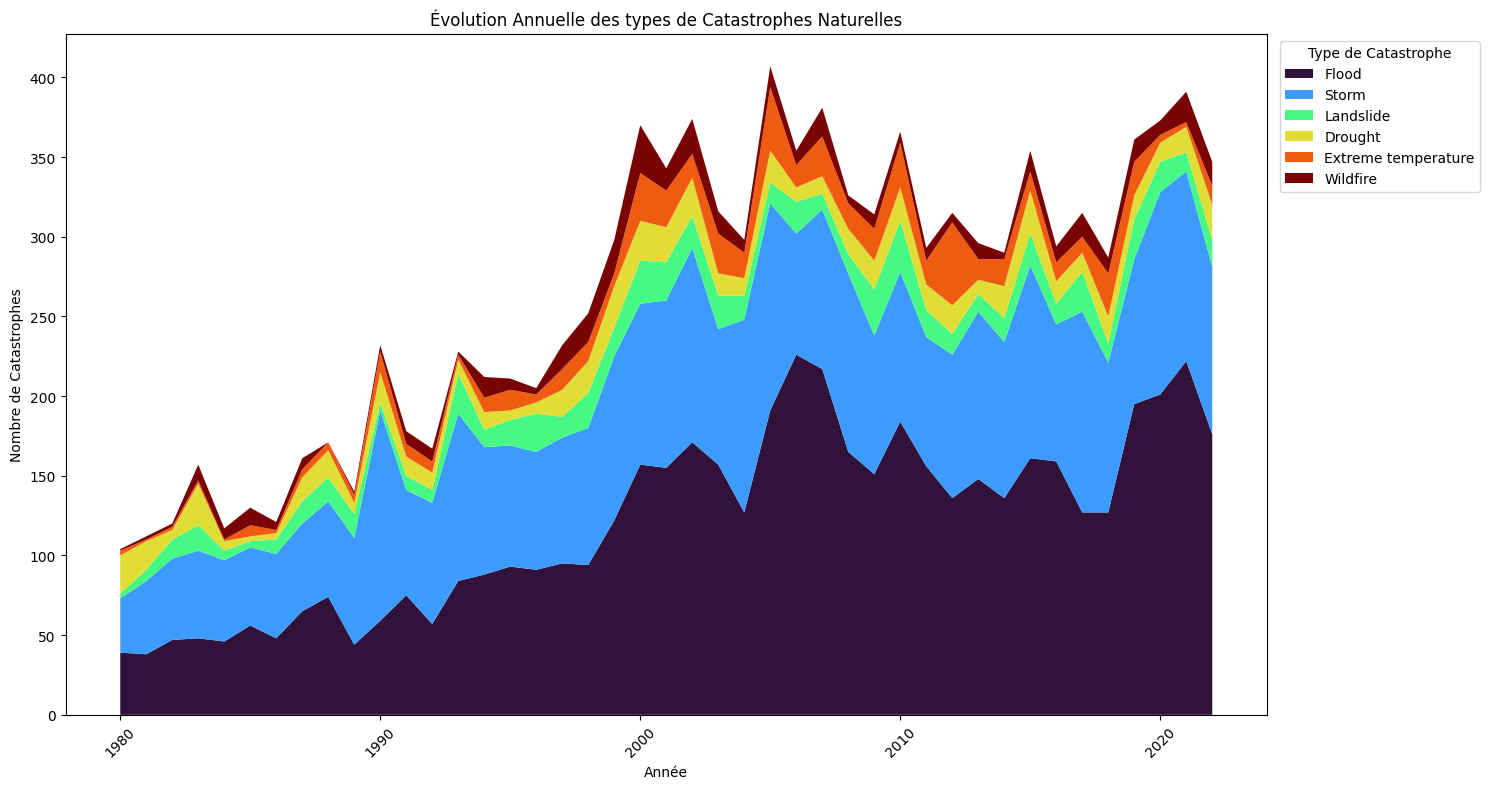

In [17]:
# Créer un tableau croisé pour avoir les années en lignes et les types de catastrophes en colonnes
pivot_data = df_disasters_world.pivot(index='Year', columns='Disaster', values='Occurrences')

# Réordonner les colonnes selon l'ordre obtenu
pivot_data = pivot_data[sorted_types]

# Créer un diagramme empilé
plt.figure(figsize=(15, 8))
plt.stackplot(pivot_data.index, pivot_data.T, labels=pivot_data.columns, colors=plt.cm.turbo(np.linspace(0, 1, len(pivot_data.columns))))
plt.title('Évolution Annuelle des types de Catastrophes Naturelles')
plt.xlabel('Année')
plt.ylabel('Nombre de Catastrophes')
plt.xticks(rotation=45)
plt.legend(title='Type de Catastrophe', bbox_to_anchor=(1.005, 1), loc='upper left')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

# Graphique à barres empilées

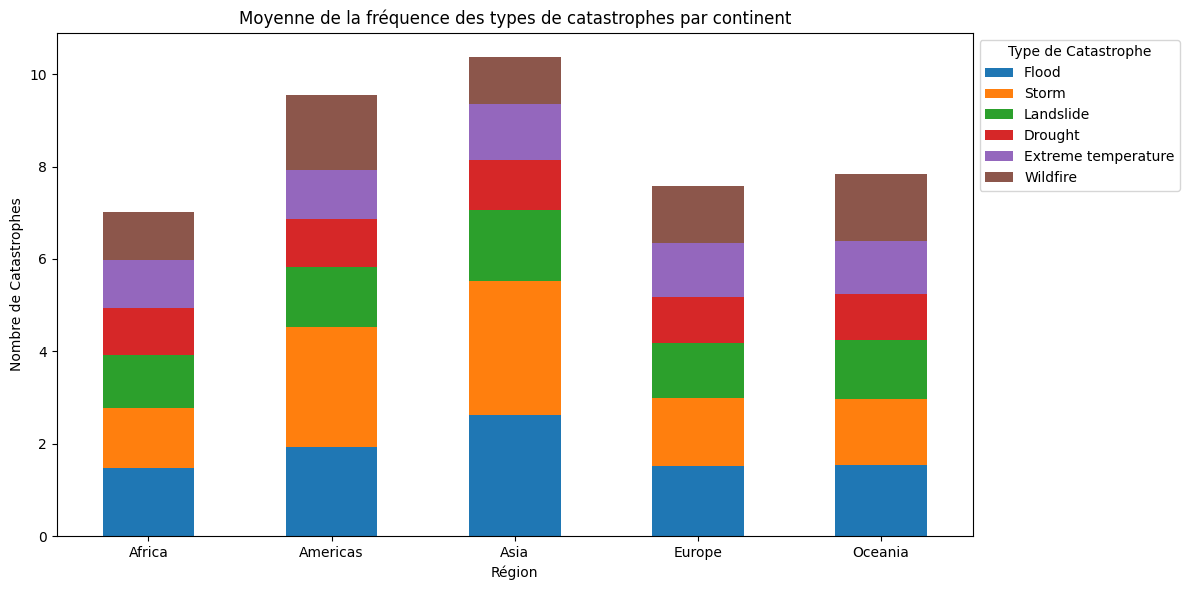

In [18]:
# Fusionner les données des catastrophes et des pays
merged_data = pd.merge(df_disasters, countries, on='ISO3')

# Regrouper par région et type de catastrophe en aggrégant les occurrences par moyenne
grouped_data = merged_data.groupby(['Region', 'Disaster']).mean("Occurrences").reset_index()

# Créer un pivot pour avoir les types de catastrophes en colonnes
pivot_data = grouped_data.pivot(index='Region', columns='Disaster', values='Occurrences').fillna(0)

# Réordonner les colonnes selon l'ordre obtenu
pivot_data = pivot_data[sorted_types]

# Créer un graphique à barres empilées
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Moyenne de la fréquence des types de catastrophes par continent')
plt.xlabel('Région')
plt.ylabel('Nombre de Catastrophes')
plt.xticks(rotation=0)
plt.legend(title='Type de Catastrophe', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

plt.show()
